In [4]:
import pandas as pd
import numpy as np
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os.path
from os import path
from sklearn.model_selection import KFold
from multiprocessing import Process, Manager, SimpleQueue
import multiprocessing
import shutil
from sklearn.metrics import accuracy_score
from rules import *
from vote_CST import *
from cv import *
from precision_CST import *
from amie import *

root = "./../../Tree_threshold_no_constant/"
cv = 3

colors_to_print = ["red",  "blue", "orange",  "violet", "darkgrey", "darkred", "darkblue", "darkorange", "darkviolet", "grey"]

# 1° Load data

In [2]:
data = pd.read_csv("./../Data/miniloan-decisions-100K.csv")

In [3]:
data

,name,creditScore,income,loanAmount,monthDuration,rate,approval,yearlyReimbursement
0,John Doe,736,113243,783440,162,0.030005,false,70648
1,John Doe,527,224186,1787385,183,0.054819,false,173197
2,John Doe,460,39954,1733494,75,0.055183,false,328563
3,John Doe,751,219998,1350004,72,0.043400,false,255970
4,John Doe,684,72470,1210944,160,0.037772,false,115742
...,...,...,...,...,...,...,...,...
99995,John Doe,366,83851,1718571,168,0.053737,false,174928
99996,John Doe,395,184259,1599473,90,0.040564,false,247703
99997,John Doe,674,242620,1099790,260,0.040825,false,76557
99998,John Doe,420,180957,1645870,203,0.049558,false,143897


# Ratios

In [4]:
ratio_names = [("income","yearlyReimbursement"), ("income","loanAmount"), ("loanAmount","rate")]

In [5]:
# Takes two features and will create the ratio f_0/f_1
def create_features_ratio(data):
    if data[data.index[1]] == 0:
        return 2147483647
    return np.round(data[data.index[0]]/data[data.index[1]], decimals=2)

In [6]:
for ratio_name in ratio_names:
    data[f"{ratio_name[0]}/{ratio_name[1]}"] = data[[ratio_name[0], ratio_name[1]]].apply(create_features_ratio, axis=1)

In [7]:
data

,name,creditScore,income,loanAmount,monthDuration,rate,approval,yearlyReimbursement,income/yearlyReimbursement,income/loanAmount,loanAmount/rate
0,John Doe,736,113243,783440,162,0.030005,false,70648,1.60,0.14,26110372.80
1,John Doe,527,224186,1787385,183,0.054819,false,173197,1.29,0.13,32605003.59
2,John Doe,460,39954,1733494,75,0.055183,false,328563,0.12,0.02,31413368.70
3,John Doe,751,219998,1350004,72,0.043400,false,255970,0.86,0.16,31106073.81
4,John Doe,684,72470,1210944,160,0.037772,false,115742,0.63,0.06,32059172.14
...,...,...,...,...,...,...,...,...,...,...,...
99995,John Doe,366,83851,1718571,168,0.053737,false,174928,0.48,0.05,31981153.44
99996,John Doe,395,184259,1599473,90,0.040564,false,247703,0.74,0.12,39430859.20
99997,John Doe,674,242620,1099790,260,0.040825,false,76557,3.17,0.22,26938940.88
99998,John Doe,420,180957,1645870,203,0.049558,false,143897,1.26,0.11,33211031.24


# 2° Find the best thresholds

In [8]:
data_raw = data.drop(columns=["name"])
false_data = data_raw[data_raw["approval"] == " false"]
true_data = data_raw[data_raw["approval"] == " true"]
data_equilibrium = true_data.append(false_data.sample(n=len(true_data)))

In [9]:
%%time

def returnSplitValue(stringToSplit):
    res = []
    tp = ""
    spliters = [("lt", "< "), ("lte", "<= "), ("gt", "> "), ("gte", ">= ")]
    i=0
    
    while i < len(spliters):
        splited = stringToSplit.split(spliters[i][1]) 
        if len(splited) == 2:
            return  spliters[i][0], float(splited[1])
        i += 1
    print("C'est casse")
    return None 


best_threshold = []
for key in data_equilibrium.keys():
    if key != "approval":
        print("\t\t"+key)
        X = data_equilibrium[[key]]

        Y = data_equilibrium["approval"]

        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
        
        model = tree.DecisionTreeClassifier(max_depth=1)
        model.fit(X_train, y_train)    

        print(f"Train Score : {accuracy_score(y_train, model.predict(X_train))}")
        print(f"Test Score : {accuracy_score(y_test, model.predict(X_test))}")
        
        if accuracy_score(y_train, model.predict(X_train)) > 0.8 and accuracy_score(y_test, model.predict(X_test)) > 0.8:
            best_threshold.append((key,)+ returnSplitValue(tree.export_text(model, spacing=1, feature_names=[key]).split("\n")[0]))
print(best_threshold)

		creditScore
Train Score : 0.5003399279352777
Test Score : 0.5003450655624568
		income
Train Score : 0.6437895166224761
Test Score : 0.6437543133195307
		loanAmount
Train Score : 0.8415595893670542
Test Score : 0.8477570738440303
		monthDuration
Train Score : 0.6127201033380923
Test Score : 0.6100759144237405
		rate
Train Score : 0.5146848868039976
Test Score : 0.5079365079365079
		yearlyReimbursement
Train Score : 0.8991773743966279
Test Score : 0.9013112491373361
		income/yearlyReimbursement
Train Score : 0.993575362023251
Test Score : 0.9928226363008972
		income/loanAmount
Train Score : 0.9229043442790128
Test Score : 0.9245686680469289
		loanAmount/rate
Train Score : 0.82636481066014
Test Score : 0.8314699792960663
[('loanAmount', 'lte', 823596.0), ('yearlyReimbursement', 'lte', 68384.5), ('income/yearlyReimbursement', 'lte', 3.33), ('income/loanAmount', 'lte', 0.24), ('loanAmount/rate', 'lte', 17652010.0)]
CPU times: user 1.27 s, sys: 15.6 ms, total: 1.28 s
Wall time: 1.28 s


# 3° Create the thresholds

Define the thresholds

In [10]:
thresholds = np.arange(0.25,1,0.25) #[0.25, 0.50, 0.75]
thresholds_str = ["-"+(str(int(i*100))) for i in thresholds]

In [11]:
# Takes a dataframe and return the values per percents for each feature
def description_per_thresholds(data, percents):
    thresholds_Dic =  {}
    for column in data.columns:
        serie = data[column]
        thresholds_Dic[column] = serie.quantile(percents)
        
    return pd.DataFrame.from_dict(thresholds_Dic)

In [12]:
def GTE_prep_df(value, valueToCompareTo):
    return value >= valueToCompareTo

def LTE_prep_df(value, valueToCompareTo):
    return value <= valueToCompareTo

def GT_prep_df(value, valueToCompareTo):
    return value > valueToCompareTo

def LT_prep_df(value, valueToCompareTo):
    return value < valueToCompareTo

In [18]:
columns = list(data.drop(columns=["name", "approval"]).columns)

booleanDF = pd.DataFrame()

for column, comparator, value in best_threshold:
    if comparator == "lte" or comparator == "gt":
        booleanDF[column+"-GT-"+str(value)] = data[column].map(lambda x : GT_prep_df(x, value))
        booleanDF[column+"-LTE-"+str(value)] = data[column].map(lambda x : LTE_prep_df(x, value))
    else:
        booleanDF[column+"-GTE-"+str(value)] = data[column].map(lambda x : GTE_prep_df(x, value))
        booleanDF[column+"-LT-"+str(value)] = data[column].map(lambda x : LT_prep_df(x, value))
    columns.remove(column)

In [19]:
description = description_per_thresholds(data[columns], thresholds)

Transform the data from integer values to boolean values corresponding to GTE or LTE with the different percents.

In [20]:
%%time

for column in columns:
    for i, value in enumerate(thresholds):
        booleanDF[column+"-GTE-"+str(int(value*100))] = data[column].map(lambda x : GTE_prep_df(x, description[column].values[i]))
        booleanDF[column+"-LTE-"+str(int(value*100))] = data[column].map(lambda x : LTE_prep_df(x, description[column].values[i]))

CPU times: user 7.22 s, sys: 46.9 ms, total: 7.27 s
Wall time: 7.27 s


In [21]:
booleanDF["approval"] = data["approval"].map({' true': True, ' false': False})
booleanDF

,loanAmount-GT-823596.0,loanAmount-LTE-823596.0,yearlyReimbursement-GT-68384.5,yearlyReimbursement-LTE-68384.5,income/yearlyReimbursement-GT-3.33,income/yearlyReimbursement-LTE-3.33,income/loanAmount-GT-0.24,income/loanAmount-LTE-0.24,loanAmount/rate-GT-17652010.0,loanAmount/rate-LTE-17652010.0,...,monthDuration-LTE-50,monthDuration-GTE-75,monthDuration-LTE-75,rate-GTE-25,rate-LTE-25,rate-GTE-50,rate-LTE-50,rate-GTE-75,rate-LTE-75,approval
0,False,True,True,False,False,True,False,True,True,False,...,True,False,True,False,True,False,True,False,True,False
1,True,False,True,False,False,True,False,True,True,False,...,False,False,True,True,False,True,False,True,False,False
2,True,False,True,False,False,True,False,True,True,False,...,True,False,True,True,False,True,False,True,False,False
3,True,False,True,False,False,True,False,True,True,False,...,True,False,True,True,False,False,True,False,True,False
4,True,False,True,False,False,True,False,True,True,False,...,True,False,True,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,True,False,True,False,False,True,False,True,True,False,...,True,False,True,True,False,True,False,True,False,False
99996,True,False,True,False,False,True,False,True,True,False,...,True,False,True,True,False,False,True,False,True,False
99997,True,False,True,False,False,True,False,True,True,False,...,False,False,True,True,False,False,True,False,True,False
99998,True,False,True,False,False,True,False,True,True,False,...,False,False,True,True,False,True,False,False,True,False


Create the folder where the data will be stored.

In [22]:
if not path.isdir(root):
    os.mkdir(root)
else : 
    shutil.rmtree(root)
    os.mkdir(root)

In [23]:
booleanDF.to_csv(root+"dfSave.csv")

# 4° Save the best data

In [24]:
# Transform an integer id to a string id
def int_to_str_id(idsInt):
    res = chr(97+idsInt%26)
    idsReducted = int(idsInt/26)
    while idsReducted != 0:
        res = chr(97+(idsReducted-1)%26) + res
        idsReducted = int(idsReducted/26)
    return res

# Syntax of Amie data
def syntax(subject, predicate, objectD):
    return f"{subject}\t{predicate}\t{objectD} \n" # Integer id
    #return f"{int_to_str_id(subject)}\t{predicate}\t{objectD} \n" #String id

# Create the text for each feature and finally write it to the file
def formatData(f, idData, data):
    toWrite = ""
    for i in data.index[:-1]:
        toWrite += syntax(idData, i, data.loc[i])
    if data.loc["approval"]:
        toWrite += syntax(idData, "approval-True", True)
    else:
        toWrite += syntax(idData, "approval-False", False)
    f.write(toWrite)

We store the data in the Amie format. 

In [25]:
f = open(root+"Knowledge_Data.tsv", "w")

booleanDF_to_Save = booleanDF
booleanDF_to_Save["approval"] = data["approval"].map({' true': True, ' false': False})

for idData in booleanDF_to_Save.index:
    formatData(f, idData, booleanDF_to_Save.iloc[idData])
    
f.close()

## Save in cross validation

In [26]:
booleanDF_to_Save = booleanDF
booleanDF_to_Save["approval"] = data["approval"].map({' true': True, ' false': False})

kf = KFold(n_splits=cv, shuffle=True, random_state=42)
kf.get_n_splits(booleanDF_to_Save)

cp = 0

for train_index, test_index in kf.split(booleanDF_to_Save):
    
    f = open(root+f"CV_train_{cp}.tsv", "w")

    for idData in train_index:
        formatData(f, idData, booleanDF_to_Save.iloc[idData])

    f.close()
    
    print("Train repartition :\n",booleanDF_to_Save.iloc[train_index]["approval"].value_counts())
    
    f = open(root+f"CV_valid_{cp}.tsv", "w")

    for idData in test_index:
        formatData(f, idData, booleanDF_to_Save.iloc[idData])

    f.close()
    
    f = open(root+f"index_{cp}.tsv", "w")

    f.write(str(train_index[0]))
    for i in range(1,len(train_index)):
        f.write(","+str(train_index[i]))
    f.write("\n")
    f.write(str(test_index[0]))
    for i in range(1,len(test_index)):
        f.write(","+str(test_index[i]))

    f.close()
    
    cp += 1

Train repartition :
 False    52004
True     14662
Name: approval, dtype: int64
Train repartition :
 False    52007
True     14660
Name: approval, dtype: int64
Train repartition :
 False    52081
True     14586
Name: approval, dtype: int64


# 5° Launch Amie

Describe the parameters.

In [2]:
atom_LIST = [2]#, 3]
minc_LIST = [0, 0.4]#, 0.8]
minpcac_LIST = [0, 0.4]#, 0.8]
minhc_LIST = [0, 0.4]#, 0.8]

Launch Amie.

In [3]:
%%capture captured

sep = "-----------------------------"

parameters = []

for i in range(cv):
    for atom in atom_LIST:
        data = f"{root}CV_train_{i}.tsv"
        !java -jar amie3.jar -htr approval-True,approval-False -maxad $atom $data
        parameters.append(f"CV={i}-A={atom}")
        print(sep)

In [6]:
%%time

res_rules_raw = run_amie(atom_LIST, root, cv, const=False)

2


CalledProcessError: Command 'java -jar ./../amie3.jar -htr approval -maxad 2 ./../../Tree_threshold_no_constant/CV_train_0.tsv' returned non-zero exit status 1.

In [7]:
!java -jar ./../amie3.jar -htr approval -maxad 2 ./../../Tree_threshold_no_constant/CV_train_0.tsv

Using the default schema relations
Assuming rdf:type as type relation
Loading files... 
  Starting CV_train_0.tsv
^C


In [4]:
#captured.stdout

Transform the raw output into sets of rules. 

In [5]:
rules_per_cv = {}
cpt = 0
for cv_res in captured.stdout.split(sep)[:-1]:
    rules = set()
    for line in cv_res.split("\n"):
        if (line != "") and (line[0] == "?"):
            dic = {}
            parts = line.split("\t")

            conclusion_raw = parts[0].split("=>")[1].split("  ")
            conclusion_raw[0] = conclusion_raw[0][1:]
            dic["conclusion"] = Atom(conclusion_raw)

            hypotheses_raw = parts[0].split("=>")[0].split("  ")
            hypotheses = []
            for i in range(0, len(hypotheses_raw)-1, 3):
                hypotheses.append(Atom(hypotheses_raw[i:i+3]))
            dic["hypotheses"] = hypotheses


            rules.add(Rule(dic["hypotheses"], dic["conclusion"], parts[1:]))
    rules_per_cv[parameters[cpt]] = rules
    cpt+=1

Retrieve the indexes for each CV.

In [6]:
indexes = retrieve_indexes(root, cv)
df = pd.read_csv(root+"dfSave.csv")

# 5° Precision

In [7]:
%%time

rules_per_para = run_precision(root, indexes, parameters, rules_per_cv)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Process n°7 : Finished
Process n°5 : Finished
Process n°3 : Finished
Process n°0 : Finished
Process n°2 : Finished
Process n°10 : Finished
Process n°6 : Finished
Process n°11 : FinishedProcess n°9 : Finished

Process n°1 : Finished
Process n°4 : Finished
Process n°8 : Finished
Process n°12 : Finished
Process n°0 : LaunchedProcess n°1 : Launched

Process n°2 : LaunchedProcess n°3 : LaunchedProcess n°4 : Launched

Process n°5 : Launched
Process n°7 : LaunchedProcess n°9 : LaunchedProcess n°6 : Launched

Process n°8 : Launched

Process n°11 : LaunchedProcess n°10 : Launched
Process n°12 : Launched


Process n°2 : Finished
Process n°5 : Finished
Process n°10 : Finished
Process n°7 : Finished
P

### Add parameters

Describe the combinaison of these new parameters.

In [8]:
new_parameters = []
for minc in minc_LIST:
    for minpcac in minpcac_LIST:
        for minhc in minhc_LIST:
            new_parameters.append([("stdConfidence", minc), ("pcaConfidence", minpcac), ("headCoverage", minhc)])
print(new_parameters)

[[('stdConfidence', 0), ('pcaConfidence', 0), ('headCoverage', 0)], [('stdConfidence', 0), ('pcaConfidence', 0), ('headCoverage', 0.4)], [('stdConfidence', 0), ('pcaConfidence', 0.4), ('headCoverage', 0)], [('stdConfidence', 0), ('pcaConfidence', 0.4), ('headCoverage', 0.4)], [('stdConfidence', 0.4), ('pcaConfidence', 0), ('headCoverage', 0)], [('stdConfidence', 0.4), ('pcaConfidence', 0), ('headCoverage', 0.4)], [('stdConfidence', 0.4), ('pcaConfidence', 0.4), ('headCoverage', 0)], [('stdConfidence', 0.4), ('pcaConfidence', 0.4), ('headCoverage', 0.4)]]


Create the DataFrames corresponding to these parameters.

In [9]:
new_dfs = add_parameters(rules_per_para, new_parameters)

Print the precision for each parameters.

<AxesSubplot:>

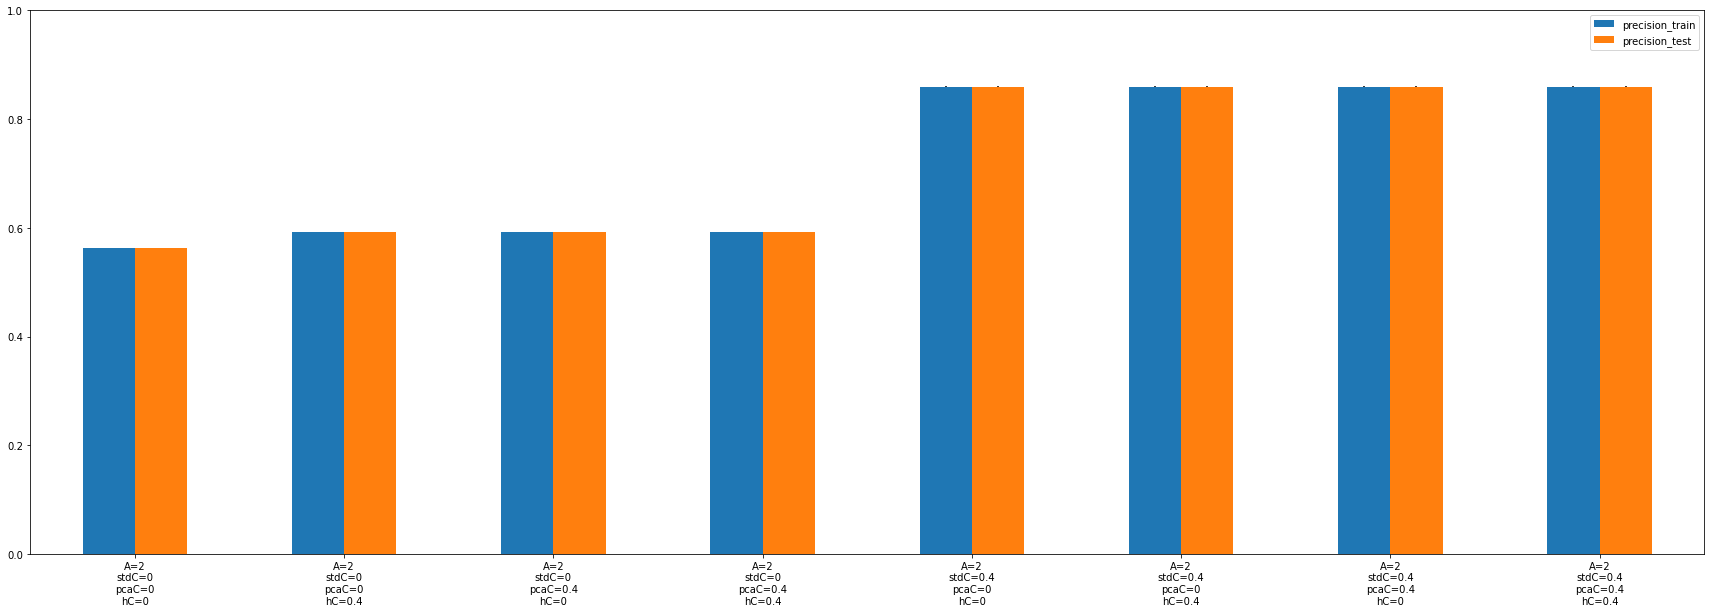

In [10]:
fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(30,10)) 
to_print, to_print_std = mean_and_std_precision(new_dfs, cv)

to_print.plot.bar(ax=_axs, rot=0, yerr=to_print_std, ylim=[0,1])

# 6° Prediction

In [11]:
to_print_save =  []
to_print_std_save = []

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : LaunchedProcess n°5 : Launched
Process n°6 : Launched

Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Value('d', 10)
Process n°8 : Finished
Process n°0 : Finished
Process n°6 : Finished
Process n°7 : Finished
Process n°12 : Finished
Process n°9 : Finished
Process n°5 : Finished
Process n°1 : Finished
Value('d', 20)
Process n°10 : Finished
Process n°11 : Finished
Process n°4 : Finished
Process n°2 : Finished
Process n°3 : Finished
24
CPU times: user 5.5 s, sys: 8.03 s, total: 13.5 s
Wall time: 4min 34s


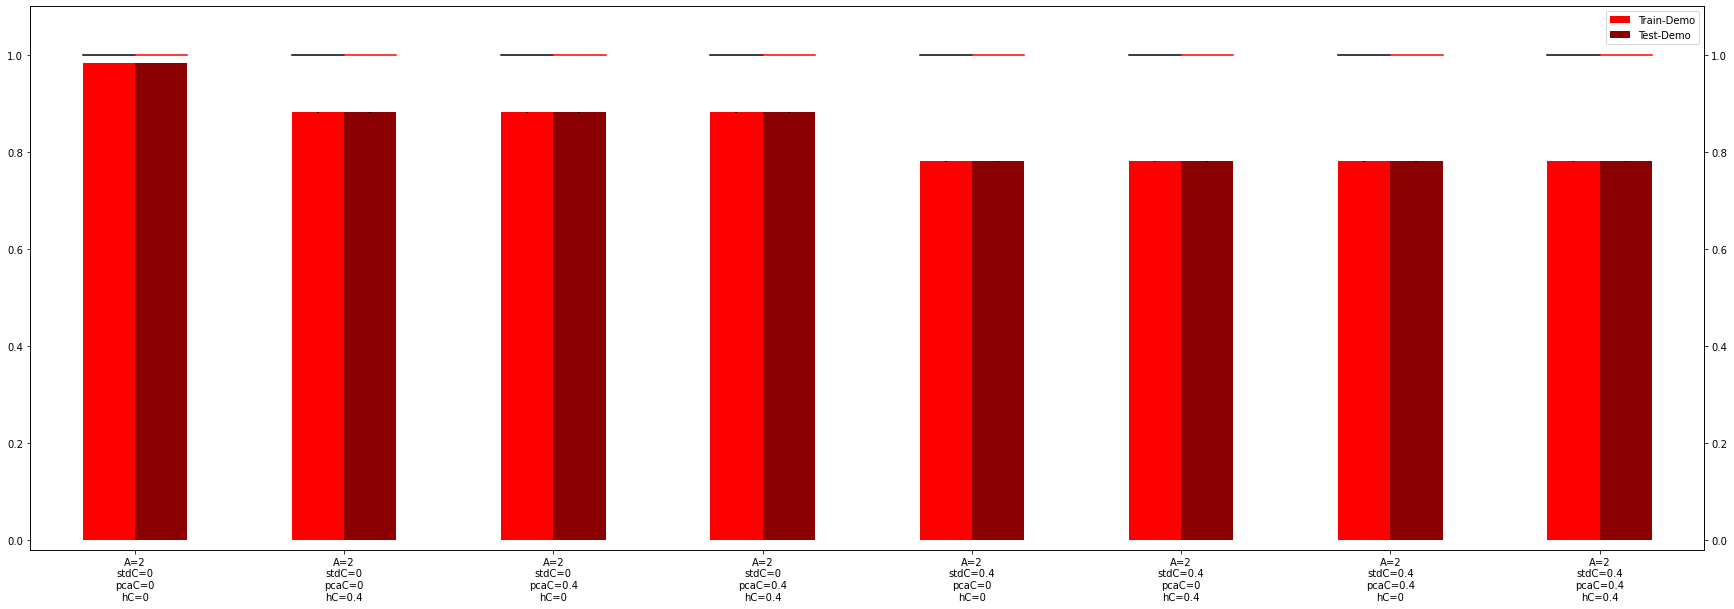

In [12]:
%%time

# prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, democracy_proportional, indexes, True)
prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, democracy, indexes, True)

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "Demo")
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

max_possible = bestScorePossible(prediction_per_rules_count)
print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Value('d', 10)
Process n°2 : Finished
Process n°0 : Finished
Process n°4 : Finished
Process n°5 : Finished
Process n°6 : Finished
Process n°8 : Finished
Process n°11 : Finished
Process n°3 : Finished
Value('d', 20)
Process n°1 : Finished
Process n°12 : Finished
Process n°9 : Finished
Process n°7 : Finished
Process n°10 : Finished
24
CPU times: user 5.56 s, sys: 8.11 s, total: 13.7 s
Wall time: 42.8 s


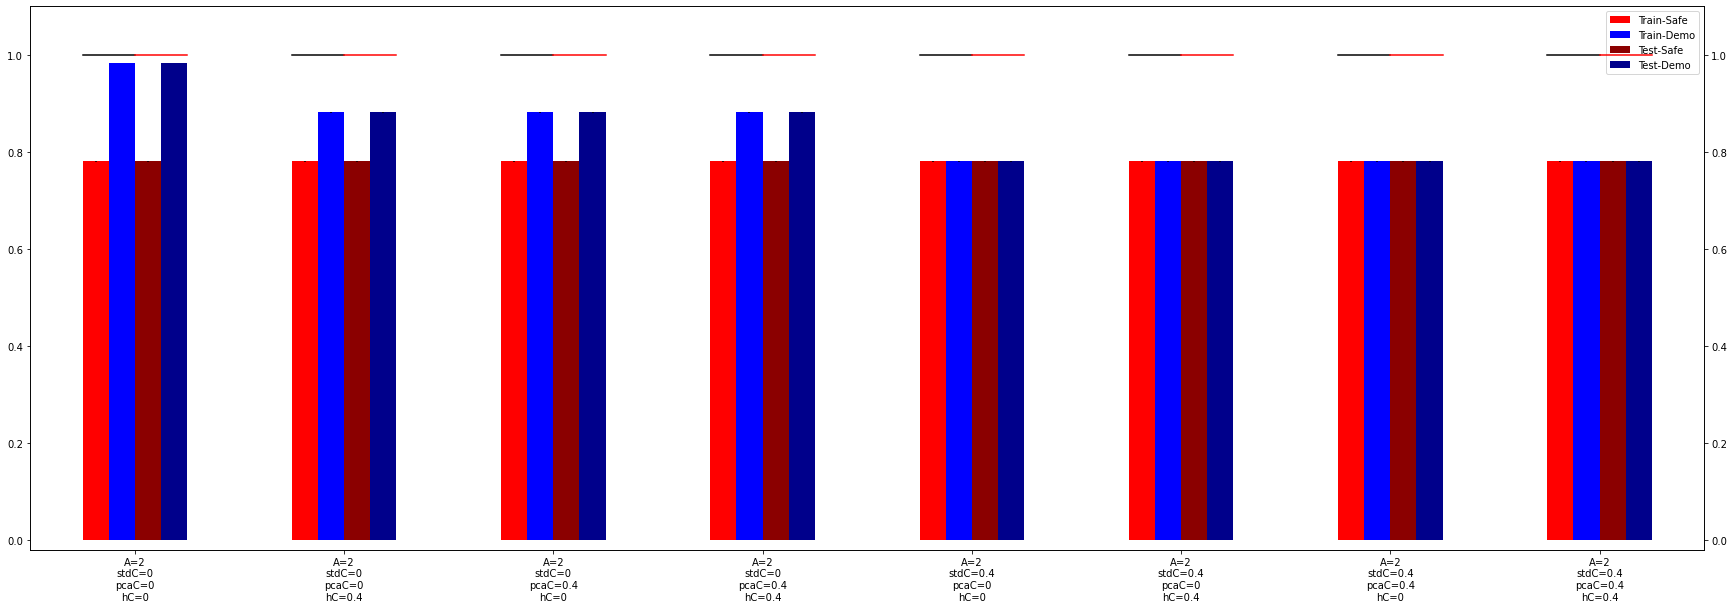

In [13]:
%%time

# prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, democracy, indexes, True)
prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, safe, indexes, True)

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "Safe")
to_print, to_print_std = merge(to_print_save[-1], to_print, to_print_std_save[-1], to_print_std)
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Value('d', 10)
Process n°6 : Finished
Process n°12 : Finished
Process n°8 : Finished
Process n°1 : Finished
Process n°11 : Finished
Process n°10 : Finished
Process n°0 : Finished
Process n°3 : Finished
Process n°2 : Finished
Process n°9 : Finished
Value('d', 20)
Process n°4 : Finished
Process n°7 : Finished
Process n°5 : Finished
24
CPU times: user 5.5 s, sys: 8.23 s, total: 13.7 s
Wall time: 1min 34s


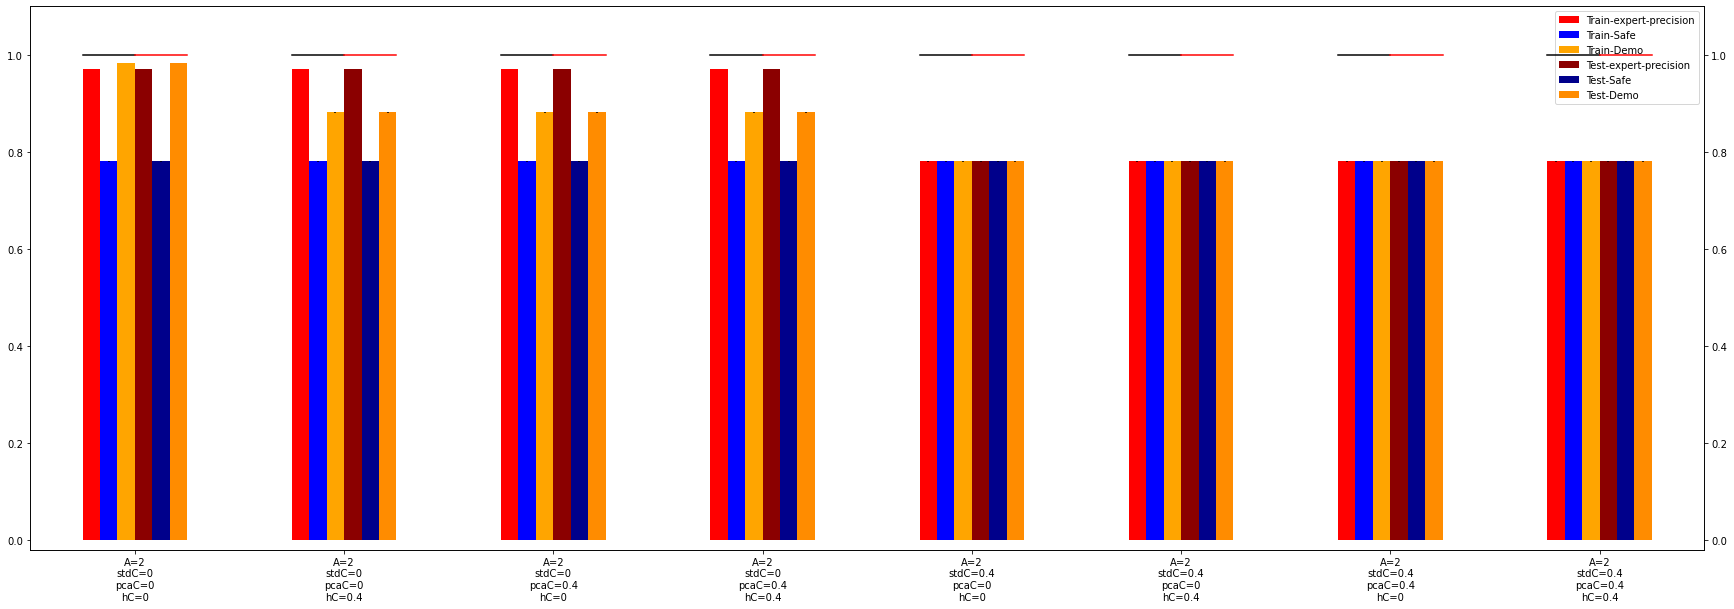

In [14]:
%%time

prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, expert, indexes, True, ranking=(["precision_train", "precision_test"], [False, False]))

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "expert-precision")
to_print, to_print_std = merge(to_print_save[-1], to_print, to_print_std_save[-1], to_print_std)
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Value('d', 10)
Process n°4 : Finished
Process n°6 : Finished
Process n°5 : Finished
Process n°0 : Finished
Process n°8 : Finished
Process n°2 : Finished
Process n°11 : Finished
Process n°9 : Finished
Value('d', 20)
Process n°7 : Finished
Process n°10 : Finished
Process n°3 : Finished
Process n°1 : Finished
Process n°12 : Finished
24
CPU times: user 5.56 s, sys: 8.19 s, total: 13.8 s
Wall time: 1min 54s


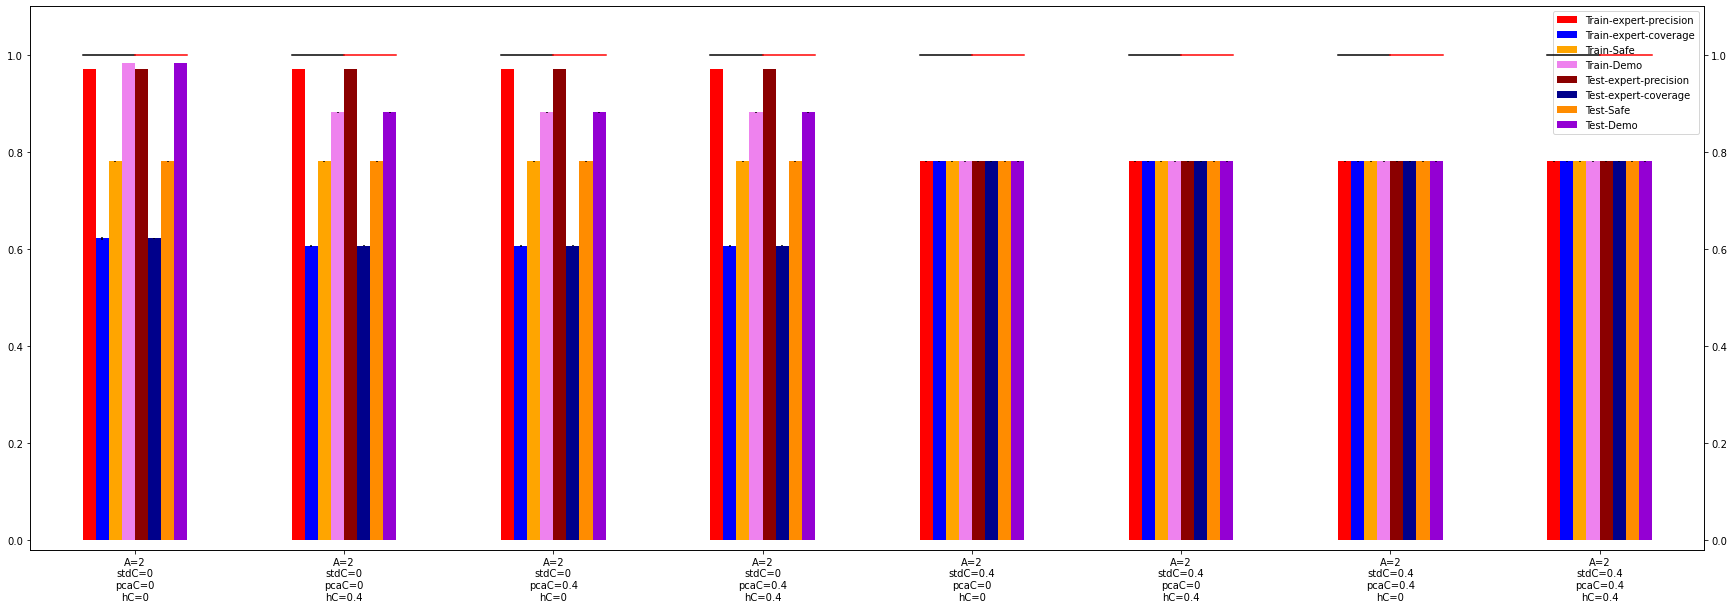

In [15]:
%%time

prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, expert, indexes, True, ranking=(["headCoverage", "precision_train", "precision_test"], [True, False, False]))

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "expert-coverage")
to_print, to_print_std = merge(to_print_save[-1], to_print, to_print_std_save[-1], to_print_std)
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Value('d', 10)
Process n°7 : Finished
Process n°6 : Finished
Process n°2 : Finished
Process n°9 : Finished
Process n°10 : Finished
Process n°8 : Finished
Process n°0 : Finished
Process n°1 : Finished
Value('d', 20)
Process n°3 : Finished
Process n°11 : Finished
Process n°4 : Finished
Process n°12 : Finished
Process n°5 : Finished
24
CPU times: user 5.47 s, sys: 8.16 s, total: 13.6 s
Wall time: 1min 37s


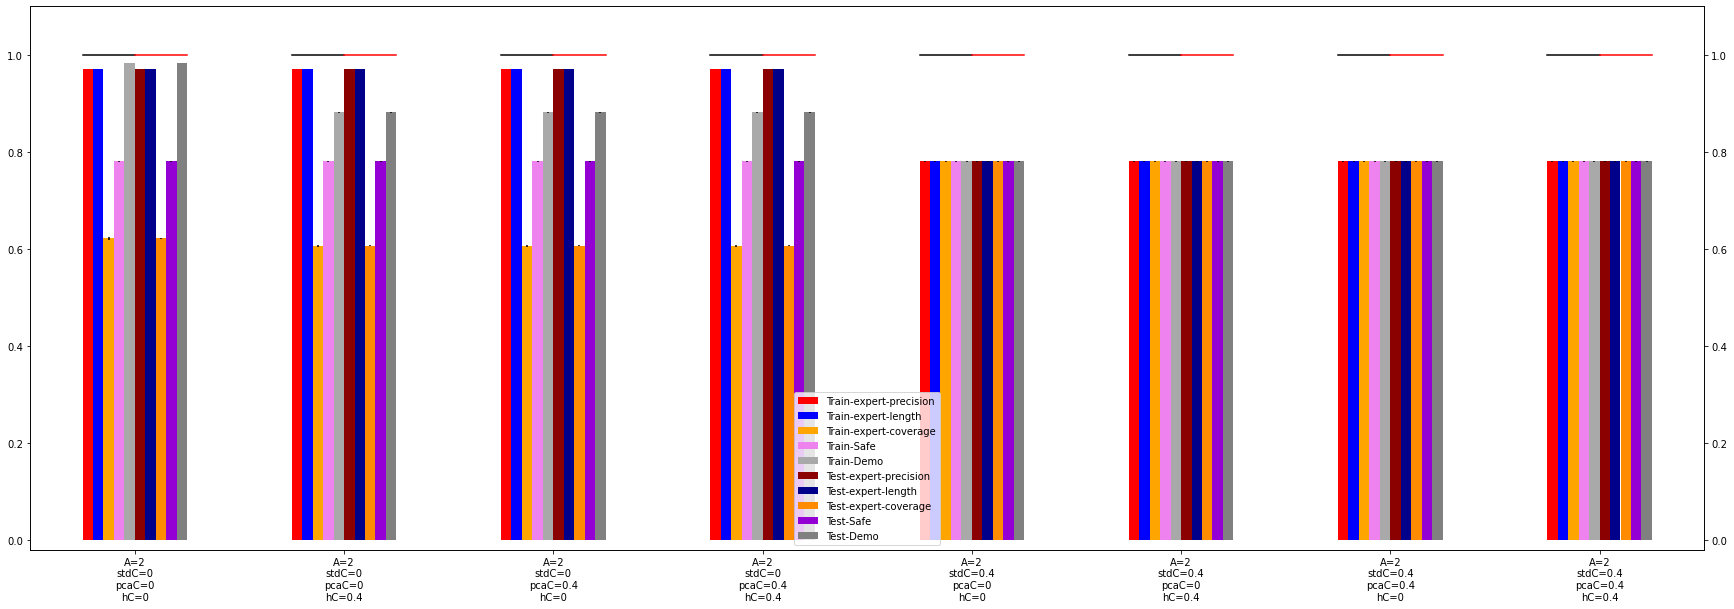

In [16]:
%%time

prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, expert, indexes, True, ranking=(["size_hypothese", "precision_train", "precision_test"], [False, False, False]))

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "expert-length")
to_print, to_print_std = merge(to_print_save[-1], to_print, to_print_std_save[-1], to_print_std)
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

In [17]:
new_dfs['CV=0-A=2\nstdC=0\npcaC=0\nhC=0'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, ?a monthDuration-GTE-25 ?b => ?a approval-False ?b to ?a monthDuration-LTE-50 ?b => ?a approval-False ?b
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hypotheses       60 non-null     object 
 1   conclusion       60 non-null     object 
 2   size_hypothese   60 non-null     int64  
 3   headCoverage     60 non-null     float64
 4   stdConfidence    60 non-null     float64
 5   pcaConfidence    60 non-null     float64
 6   precision_train  60 non-null     float64
 7   precision_test   60 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 4.2+ KB


In [18]:
new_dfs['CV=0-A=2\nstdC=0\npcaC=0\nhC=0'].describe()

,size_hypothese,headCoverage,stdConfidence,pcaConfidence,precision_train,precision_test
count,60.0,60.000000,60.000000,60.000000,60.000000,60.000000
mean,1.0,0.560321,0.281686,0.560321,0.562369,0.562340
std,0.0,0.257146,0.198940,0.257146,0.288951,0.289424
min,1.0,0.120914,0.052636,0.120914,0.114460,0.116262
25%,1.0,0.284934,0.140308,0.284934,0.231869,0.229313
50%,1.0,0.532434,0.199487,0.532434,0.653690,0.656999
75%,1.0,0.749744,0.401310,0.749744,0.781410,0.783913
max,1.0,0.999659,0.769988,0.999659,0.999903,0.999766


In [19]:
new_dfs['CV=0-A=2\nstdC=0\npcaC=0.4\nhC=0'].describe()

,size_hypothese,headCoverage,stdConfidence,pcaConfidence,precision_train,precision_test
count,41.0,41.000000,41.000000,41.000000,41.000000,41.000000
mean,1.0,0.703516,0.348003,0.703516,0.592742,0.592746
std,0.0,0.173125,0.205050,0.173125,0.291586,0.292400
min,1.0,0.419452,0.092251,0.419452,0.170533,0.170693
25%,1.0,0.517255,0.164852,0.517255,0.265045,0.265239
50%,1.0,0.739667,0.337098,0.739667,0.701596,0.705536
75%,1.0,0.796131,0.574401,0.796131,0.787173,0.787374
max,1.0,0.999659,0.769988,0.999659,0.999903,0.999766


In [20]:
new_dfs['CV=0-A=2\nstdC=0\npcaC=0\nhC=0.4'].describe()

,size_hypothese,headCoverage,stdConfidence,pcaConfidence,precision_train,precision_test
count,41.0,41.000000,41.000000,41.000000,41.000000,41.000000
mean,1.0,0.703516,0.348003,0.703516,0.592742,0.592746
std,0.0,0.173125,0.205050,0.173125,0.291586,0.292400
min,1.0,0.419452,0.092251,0.419452,0.170533,0.170693
25%,1.0,0.517255,0.164852,0.517255,0.265045,0.265239
50%,1.0,0.739667,0.337098,0.739667,0.701596,0.705536
75%,1.0,0.796131,0.574401,0.796131,0.787173,0.787374
max,1.0,0.999659,0.769988,0.999659,0.999903,0.999766
